# Profiling Early Defects upon Eomes KD

In [1]:
here::i_am("rna_atac/differential/v2/01_early_defects.ipynb")

source(here::here("settings.R"))
source(here::here("utils.R"))

suppressPackageStartupMessages(library(scran))
suppressPackageStartupMessages(library(scater))
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(edgeR))
suppressPackageStartupMessages(library(ArchR))

BPPARAM <- BiocParallel::bpparam()
BPPARAM$workers = 16

# Multi core using future - built in to seurat
plan("multicore", workers = 16)
options(future.globals.maxSize = 50 * 1024 ^ 3) # for 50 Gb RAM



here() starts at /rds/project/rds-SDzz0CATGms/users/bt392/09_Eomes_invitro_blood/code

Warning message:
“package ‘rtracklayer’ was built under R version 4.2.3”

                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | 

In [2]:
# Define custom functions
plot_region = function(input_gene, gene_height = 1.5, no_label = F, bw_width = 10, bw_height = 10, extend.upstream = 3e3, extend.downstream = 3e3 ){
    tmp1 = DEG_DAR[celltype %in% args$celltypes & gene %in% input_gene] %>% 
        .[order(-abs(ATAC_logFC))] %>% unique(by = 'peak')
    gene_region = ArchRProject@geneAnnotation$genes[grep(paste0('^', input_gene, '$'), ArchRProject@geneAnnotation$genes$symbol)]
    peak_regions = as.numeric(str_split(str_split(tmp1$peak, ':') %>% map_chr(2), '-') %>% map_chr(1))
    start = min(c(start(ranges(gene_region)), peak_regions)) - extend.downstream
    end = max(c(c(end(ranges(gene_region)), peak_regions + 600))) + extend.upstream
    input_region = paste0(gene_region@seqnames@values, ':', start, '-', end)

    mypal <- colorRampPalette(c("#fff7b8","grey98","#d0ffc2"))(100)
    x <- tmp1[, ATAC_logFC]
    highlight_colors = map2color(x,mypal, limits = c(-max(abs(c(0,x))), max(abs(c(0,x)))))
    names(highlight_colors) = str_split(str_split(tmp1[, peak], ':') %>% map_chr(2), '-') %>% map_chr(1)

    plot_browser_track(gene = input_gene, # gene used for plotting expression
                                  input_region = input_region, # Region used
                                  bigwigs = WT_plot, 
                                  extend.upstream = 0,
                                  extend.downstream = 0, 
                                  highlight_regions = if(length(tmp1$peak)>0){tmp1$peak}else{NULL},
                                  downsample.rate = 1, 
                                  no_label = no_label, 
                                  plot_expression = T,
                                  background_color = 'white',
                                  highlight_color = if(length(highlight_colors)>0){highlight_colors}else{NULL},
                                  bw_height = bw_height, 
                                  gene_height = gene_height,
                                  bw_width = bw_width)
}

plot_enr_heatmap = function(motif_enrichment, ntop=25, TFs = NULL, title = 'Motifs in marker peaks', subtitle = NULL, color = 'darkblue') {

    if(!is.null(TFs)){
        keep_tfs = TFs
    }else{
        keep_tfs = motif_enrichment %>% .[,variable:=factor(celltype, levels= names(opts$celltype_v2.colors))] %>% .[order(c(celltype, -mlog10Padj))] %>% .[, head(.SD, ntop),  by=celltype] %>% .$feature   
    }
    
    enriched.dt = motif_enrichment[feature %in% keep_tfs] %>% .[order( -mlog10Padj)] %>% 
        #.[,TF:=strsplit(TF, '_') %>% map_chr(1)] %>%
         .[,feature:=factor(feature, levels=unique(keep_tfs))] %>%
        .[,variable:=factor(celltype, levels=names(opts$celltype_v2.colors))]
    
    p = ggplot(enriched.dt, aes(feature, celltype, color = Enrichment, size=mlog10Padj)) + 
        geom_point() +
        scale_color_gradient2(low='white', mid = 'white', high=color, name='Enrichment', midpoint = 0) + # , breaks = c(0,100), labels = c('Min', 'Max')
        scale_y_discrete(expand = c(0, 0.5)) + 
        scale_x_discrete(expand = c(0, 0.5)) + 
        geom_hline(yintercept=seq(.5, 20, 1), alpha=0.2) + 
        geom_hline(yintercept=c(6.5, 7.5), alpha=1) + 
        guides(colour = guide_colourbar(
            # barwidth = 1, barheight = 1,
            frame.colour = "black", 
            ticks.colour = "black"
        )) + 
        labs(title = title, caption = subtitle) + 
        theme(text=element_text(size=12), 
             axis.text = element_text(color='black'),
             axis.text.x=element_text(angle=-90,hjust=0,vjust=0.5, size=12), 
             axis.text.y= element_text(hjust=1, size = 12), # element_blank(), #
             axis.title = element_blank(),
             panel.border = element_rect(color='black', linewidth=1, fill = NA),
             panel.background = element_blank(),
             plot.title = element_text(size=14, face='plain', hjust=0.5),
             axis.line = element_blank(),
             legend.title = element_text(hjust=0, vjust = 0.85),
             legend.text = element_text(hjust=0.5, vjust = 0.5),
             legend.position = 'bottom')
    
p
    return(p)
}

In [3]:
args = list()

# Metadata
args$metadata = file.path(io$basedir, 'results/rna_atac/clustering/metadata_celltype_annotated_v2.txt.gz')

# RNA_sce
args$rna_sce = file.path(io$basedir, 'processed/rna/SingleCellExperiment.rds')

# Load Differential analysis
args$expression = file.path(io$basedir, 'results/rna_atac/differential/v2/expression/')
args$accessibility = file.path(io$basedir, 'results/rna_atac/differential/v2/Accessibility/')
args$WT_trajectory = file.path(io$basedir, 'results/rna_atac/trajectory/v3')

# outdir
args$outdir = file.path(io$basedir, 'results/rna_atac/differential/v2/01_early_defects/')
dir.create(args$outdir, recursive=TRUE, showWarnings =FALSE)

# Celltypes to use
args$celltypes = c('Primitive_Streak', 'Early_Mes_EOi')

In [4]:
# Load browser track files
ArchRProject = suppressMessages(ArchR::loadArchRProject(io$archR.directory))

args$vitro_bws = file.path(io$basedir, 'processed/atac/archR/GroupBigWigs/celltypeV2_genotype/')

bigwigs.data_vitro = data.table(celltype = list.files(args$vitro_bws, 'bw') %>% str_split(., '\\.') %>% map_chr(1),
                    genotype = list.files(args$vitro_bws, 'bw') %>% str_split(., '\\.') %>% map_chr(2) %>% str_split('-') %>% map_chr(1),
                    path =  paste0(args$vitro_bws, list.files(args$vitro_bws, 'bw'))) %>% 
                .[,name := paste0(str_replace_all(celltype, opts$celltype_v2_figure), ' ', gsub('KO', 'KD', genotype))] %>% 
                .[,color := ifelse(genotype == 'KO', '#FF0000', '#000000')] %>% 
                .[name != 'Blood_Progenitor-KO']

bigwig_order = c(
                'Primitive Streak WT','Primitive Streak KD',
                'Early-Mes #1 WT','Early-Mes #1 KD'
)
WT_plot = bigwigs.data_vitro %>% copy() %>%
    .[genotype %in% c('WT', 'KO')] %>% 
    .[match(bigwig_order, name)] %>% 
    .[, name := factor(name, levels = bigwig_order)]

In [5]:
# Load meta
meta = fread(args$metadata)[day!='D3']

#### Load Data

In [6]:
# load sce
rna.sce <- load_SingleCellExperiment(args$rna_sce, normalise = TRUE, cells = meta$cell)
colData(rna.sce) = meta %>% as.data.frame() %>% tibble::column_to_rownames('cell') %>% DataFrame()

In [7]:
test = meta %>% copy() %>% .[, gene := as.vector(logcounts(rna.sce['Bmp4',]))] %>% 
    .[, mean := mean(gene), by = c('genotype', 'celltype_v2')] %>% unique(by = c('genotype', 'celltype_v2')) %>% .[order(celltype_v2, genotype)]

In [ ]:
# Load differential RNA
DEGs = fread(sprintf('%s/DEGs_edgeR_pb.txt.gz', args$expression))[celltype %in% args$celltypes] %>% 
        .[,sig:=ifelse(abs(logFC)>0.5 & padj_fdr < 0.05, TRUE, FALSE)] %>% 
        .[sig == T] %>% .[, sig := NULL]
DEGs = DEGs[!gene %in% c('Hba-x', 'Hba-a1', 'Hba-a2', 'Hbb-bh1')]

# Load differential ATAC
DARs = fread(sprintf('%s/DARs_edgeR_pb.txt.gz', args$accessibility))[celltype %in% args$celltypes] %>% 
        .[,sig:=ifelse(abs(logFC)>0.5 & padj_fdr < 0.05, TRUE, FALSE)] %>% 
        .[sig == T] %>% .[, sig := NULL]

# Load peak2gene linkage
peak_gene_correlation = fread(file.path(args$WT_trajectory, 'acc_gene_correlation.txt.gz')) %>% 
    # .[padj<0.05] %>% 
    .[]

# Get differential genes from trajectory analysis between the two lineages in WT
patternGenes = fread(file.path(args$WT_trajectory, 'patternGenes.txt.gz'))
endGenes = fread(file.path(args$WT_trajectory, 'endGenes.txt.gz'))
genes_keep = unique(rbind(patternGenes[,c('gene', 'waldStat', 'padj', 'sig')], endGenes[,c('gene', 'waldStat', 'padj', 'sig')])[sig==TRUE][order(padj, -waldStat)]$gene)

In [ ]:
fread(sprintf('%s/DEGs_edgeR_pb.txt.gz', args$expression))[gene == 'Pitx1']

gene,logFC,padj_fdr,mean_groupA,mean_groupB,cdr_groupA,cdr_groupB,celltype
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Pitx1,NA,NA,2.25,3.11,0.05,0.09,PGC
Pitx1,0.098,3.99e-03,8.00,8.02,0.90,0.95,Allantois
Pitx1,0.272,1.26e-06,6.82,7.06,0.71,0.76,Allantois_Precursor
Pitx1,0.650,3.64e-09,5.06,5.65,0.29,0.40,Mesenchyme
Pitx1,NA,NA,4.63,4.29,0.21,0.19,Posterior_Mes
Pitx1,NA,NA,1.20,0.69,0.01,0.01,Early_Mes_EOi
Pitx1,NA,NA,0.99,1.81,0.01,0.03,Primitive_Streak
Pitx1,NA,NA,0.66,0.25,0.01,0.00,Early_Mes_EOd
Pitx1,NA,NA,0.77,1.38,0.01,0.03,HE_Precursor


# RNA

Warning message:
“Vectorized input to `element_text()` is not officially supported.
ℹ Results may be unexpected or may change in future versions of ggplot2.”


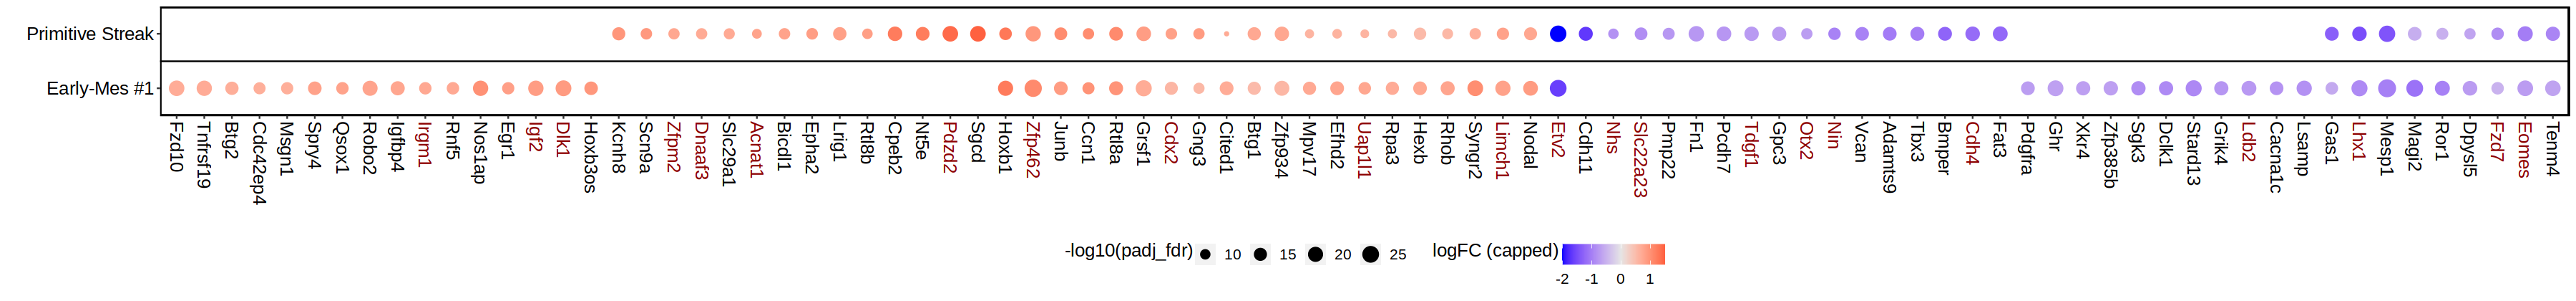

In [20]:
features = DEGs %>% 
    .[order(-abs(logFC)),] %>% 
    .[,head(.SD, 50), by=celltype] %>% .$gene

# Turn dt in matrix
DEGs.mtx = DEGs[gene %in% features, c('gene',  'logFC', 'celltype')] %>% dcast(., celltype ~ gene, value.var = 'logFC')
DEGs.mtx[is.na(DEGs.mtx)] = 0
DEGs.mtx = DEGs.mtx %>% as.data.frame() %>% tibble::column_to_rownames('celltype')

# Cluster genes by logFC
order = hclust(dist(t(DEGs.mtx)))

# prepare data.table for plotting
to.plot = DEGs[gene %in% features & padj_fdr < 0.05] %>%
     # .[abs(logFC) > args$logFC_thr] %>% 
    .[, gene := factor(gene, levels = order$labels[order$order])] %>%
    .[, celltype_figure := opts$celltype_v2_figure[match(celltype, names(opts$celltype_v2_figure))]] %>% 
    .[, logFC_capped := ifelse(logFC >= 2, 2, 
                               ifelse(logFC <= -2, -2, logFC))]

options(repr.plot.width=30, repr.plot.height=3.5)
ggplot(to.plot, aes(gene, celltype_figure, size=-log10(padj_fdr), col=logFC_capped)) + 
    geom_point() + 
    scale_color_gradient2(low='blue', mid = 'gray90', high='red', name='logFC (capped)') + 
    xlab('') + ylab('') +
    geom_hline(yintercept=seq(.5, 20, 1), alpha=0.2) + 
    geom_hline(yintercept=c(1.5, 2.5), alpha=1) + 
    scale_y_discrete(limits = c('Early-Mes #1', 'Primitive Streak'), expand = c(0, 0.5)) + 
    # ggtitle('Eomes KD vs WT Expression') + 
    theme(axis.text.x = element_text(angle=-90, hjust=0, vjust=0.5, color = ifelse(unique(to.plot[order(gene)]$gene) %in% genes_keep, 'darkred', 'black')),
         axis.text=element_text(size=15, color='black'),
         text=element_text(size=15),
            panel.border = element_rect(color='black', linewidth=1, fill = NA),
            panel.background = element_blank(),
            axis.line = element_blank(),
          legend.position = 'bottom',
          legend.title = element_text(vjust=1)
)

In [326]:
DEGs[grep('Krt', gene)]

gene,logFC,padj_fdr,mean_groupA,mean_groupB,cdr_groupA,cdr_groupB,celltype
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Krt8,0.553,8.16e-12,5.68,6.25,0.3,0.52,Primitive_Streak


Warning message:
“Vectorized input to `element_text()` is not officially supported.
ℹ Results may be unexpected or may change in future versions of ggplot2.”


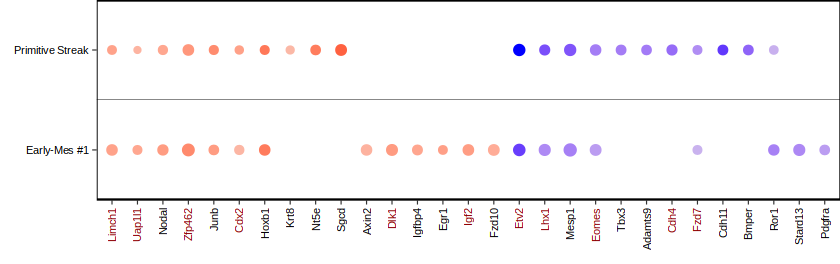

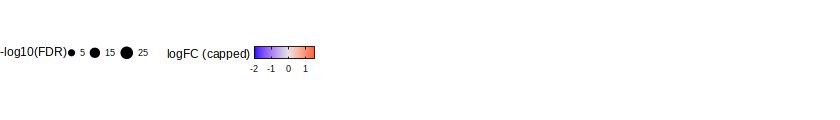

In [357]:
# Select genes to plot
genes_plot = c('Limch1', 'Uap1l1', 'Nodal', 'Zfp462', 'Junb', 'T', 'Cdx2', 'Hoxb1', 'Krt8', 'Nt5e', 'Sgcd',
              'Axin2', 'Dlk1', 'Igfbp4', 'Egr1', 'Igf2', 'Fzd10', 'Bnip3', 
              'Etv2', 'Lhx1', 'Mesp1', 'Eomes', 'Tbx3', 'Adamts9', 'Cdh4',  'nin', 'Fzd7', 'Cdh11', 'Bmper',
              'Ror1', 'Stard13', 'Pdgfra')

# prepare data.table for plotting
to.plot = DEGs[gene %in% genes_plot & padj_fdr < 0.05] %>%
     # .[abs(logFC) > args$logFC_thr] %>% 
    .[, gene := factor(gene, levels = genes_plot)] %>%
    .[, celltype_figure := opts$celltype_v2_figure[match(celltype, names(opts$celltype_v2_figure))]] %>% 
    .[, logFC_capped := ifelse(logFC >= 2, 2, 
                               ifelse(logFC <= -2, -2, logFC))]

p1 = ggplot(to.plot, aes(gene, celltype_figure, size=-log10(padj_fdr), col=logFC_capped)) + 
    geom_point() + 
    scale_size(range = c(-0.3, 2.7), limits = c(0, max(-log10(to.plot$padj_fdr))), breaks = c(5, 15, 25),
                             name = '-log10(FDR)') +  
    scale_color_gradient2(low='blue', mid = 'gray90', high='red', name='logFC (capped)') + 
    xlab('') + ylab('') +
    geom_hline(yintercept=c(1.5), linewidth = 0.1) + 
    scale_y_discrete(limits = c('Early-Mes #1', 'Primitive Streak'), expand = c(0, 0.5)) + 
    guides(
        size = guide_legend(order = 1),
        colour = guide_colourbar(
            barwidth = 2.5, barheight = 0.5,
            frame.colour = "black", 
            ticks.colour = "black",
            order = 2
        )
    ) + 
    theme(
            axis.text.x=element_text(angle=90,hjust=1,vjust=0.5, size=6, color = ifelse(unique(to.plot[order(gene)]$gene) %in% genes_keep, 'darkred', 'black')), 
            axis.text = element_text(size=6, color='black'),
            text=element_text(size=6),
            panel.border = element_rect(color='black', linewidth=0.5, fill = NA),
            panel.background = element_blank(),
            axis.line = element_blank(),
            axis.ticks=element_line(linewidth=0.25),
            plot.margin = margin(0, 0, 0, 0),  # Adjust the margin around the plot
            legend.position = 'bottom',
            legend.title = element_text(vjust=0.85, size = 7),
            legend.margin = margin(0, 0, 0, 0),  # Adjust the margin inside the legend box
            legend.box.margin = margin(0, 0, 0, 0),  # Adjust the margin outside the legend box
            legend.key.size  = unit(1, "mm"),
            legend.key = element_blank(),
            legend.justification = "left" 
    )

options(repr.plot.width=7, repr.plot.height=2.2)
p1 + theme(legend.position = 'none')
options(repr.plot.width=7, repr.plot.height=1)
grid.newpage()                               
grid.draw(get_legend(p1))

In [358]:
ggsave(file.path(io$basedir, 'figures/multiome_KD_Early_DEGs.pdf'), 
       plot = p1 + theme(legend.position = 'none'),
       width = 80, 
       height = 25, 
       units = "mm")

ggsave(file.path(io$basedir, 'figures/multiome_KD_Early_DEGs_legend.pdf'), 
       plot = as_ggplot(get_legend(p1)),
       width = 70, 
       height = 10, 
       units = "mm")

### ATAC

In [329]:
# matches <- getMatches(ArchRProject, 'Motif_cisbp')
# rownames(matches) = rownames(atac.sce)

io$multiome = '/rds/project/rds-SDzz0CATGms/users/bt392/09_Eomes_invitro_blood/results/multiome_atlas/'
silico_chip = readRDS(file.path(io$multiome, 'vitro_peaks_silicoChIP_cisbp.rds'))
assay(silico_chip, 'matches') = assay(silico_chip, 'VirtualChipScores') > 0.20 # keep only motifs with in silico score > 0.2
assay(silico_chip, 'motifScores') = NULL
assay(silico_chip, 'motifMatches') = NULL
assay(silico_chip, 'motifCounts') = NULL
assay(silico_chip, 'VirtualChipScores') = NULL
matches = silico_chip

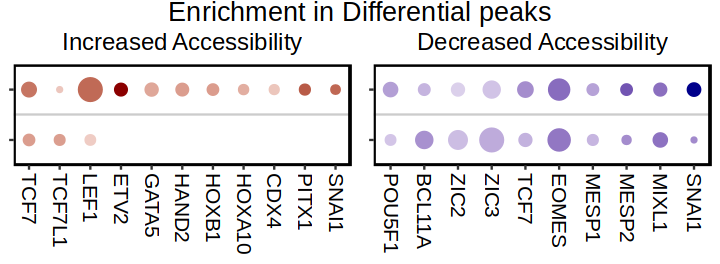

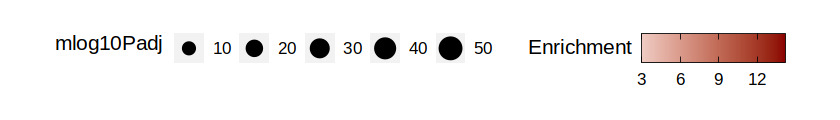

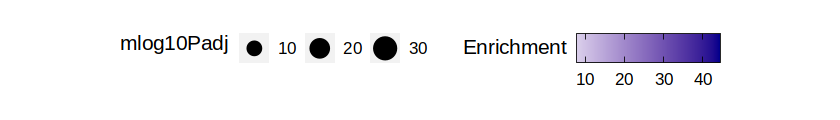

In [330]:
ntop = 20
options(repr.plot.width=8, repr.plot.height=4)

up = lapply(args$celltypes, function(x){
    tmp = as.data.table(ArchR:::.computeEnrichment(matches, DARs[celltype == x & logFC > 0.5 & padj_fdr < 5e-3, peak], seq_len(nrow(matches)))) %>%
            .[,feature := str_split(feature, '_') %>% map_chr(1)] %>% 
            .[mlog10Padj > -log10(0.05)] %>% 
            .[,celltype := x]
    return(tmp)
}) %>% rbindlist() %>% 
    .[, celltype := factor(celltype, levels = args$celltypes)]
p2 = plot_enr_heatmap(up, TFs = c('TCF7', 'TCF7L1', 'LEF1', 'ETV2', 'GATA5', 'HAND2', 'HOXB1', 'HOXA10', 'CDX4', 'PITX1', 'SNAI1'), title = 'Increased Accessibility', color = 'darkred')
# Plot Hand2 instead of Hand1
down = lapply(args$celltypes, function(x){
    tmp = as.data.table(ArchR:::.computeEnrichment(matches, DARs[celltype == x & logFC <= -0.5 & padj_fdr < 5e-3, peak], seq_len(nrow(matches)))) %>%
            .[,feature := str_split(feature, '_') %>% map_chr(1)] %>% 
            .[mlog10Padj > -log10(0.05)] %>% 
            .[,celltype := x]
    return(tmp)
}) %>% rbindlist() %>% 
    .[, celltype := factor(celltype, levels = args$celltypes)]
p3 = plot_enr_heatmap(down, TFs = c('POU5F1', 'BCL11A', 'ZIC2', 'ZIC3', 'TCF7', 'EOMES', 'MESP1', 'MESP2', 'MIXL1',  'SNAI1'), title = 'Decreased Accessibility')

options(repr.plot.width=6, repr.plot.height=2.2)
ggarrange(p2 + theme(axis.text.y = element_blank(), legend.position = 'none'), 
          NULL, 
          p3 + theme(axis.text.y = element_blank(), legend.position = 'none'), 
          align = 'h', widths = c(1, -0.0, 1), nrow = 1) + 
    ggtitle('Enrichment in Differential peaks') + 
    theme(plot.title = element_text(size = 16, hjust = 0.5),
            #plot.title.position = "plot",
            plot.margin = unit(c(0,0, 0, 0), 'lines'))

options(repr.plot.width=7, repr.plot.height=1)
grid.newpage()                               
grid.draw(get_legend(p2))

options(repr.plot.width=7, repr.plot.height=1)
grid.newpage()                               
grid.draw(get_legend(p3))

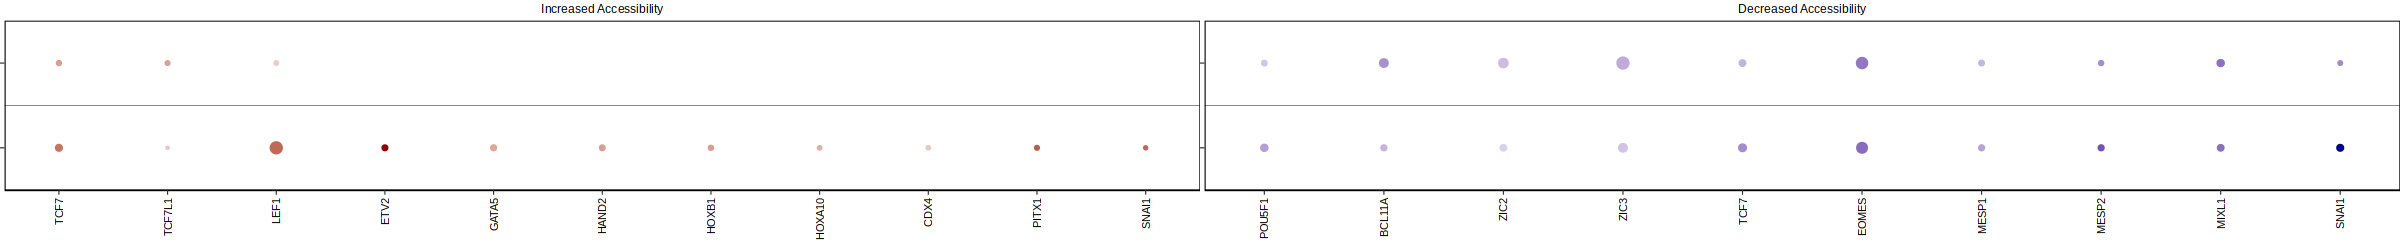

In [354]:
plot_enr_heatmap = function(motif_enrichment, ntop=25, TFs = NULL, title = 'Motifs in marker peaks', subtitle = NULL, color = 'darkblue') {

    if(!is.null(TFs)){
        keep_tfs = TFs
    }else{
        keep_tfs = motif_enrichment %>% .[,variable:=factor(celltype, levels= names(opts$celltype_v2.colors))] %>% .[order(c(celltype, -mlog10Padj))] %>% .[, head(.SD, ntop),  by=celltype] %>% .$feature   
    }
    
    enriched.dt = motif_enrichment[feature %in% keep_tfs] %>% .[order( -mlog10Padj)] %>% 
        #.[,TF:=strsplit(TF, '_') %>% map_chr(1)] %>%
         .[,feature:=factor(feature, levels=unique(keep_tfs))] %>%
        .[,variable:=factor(celltype, levels=names(opts$celltype_v2.colors))]
    
    pretty_breaks <- function(n = 3) {
      function(x) pretty(x, n = n)
    }
    
    p = ggplot(enriched.dt, aes(feature, celltype, color = Enrichment, size=mlog10Padj)) + 
        geom_point() +
        scale_color_gradient2(low='white', mid = 'white', high=color, name='Enrichment', 
                              midpoint = 0, limits = c(0, max(enriched.dt$Enrichment))) + # , breaks = c(0,100), labels = c('Min', 'Max')
        scale_size(range = c(-0.3, 2.7), 
                   limits = c(0, max(enriched.dt$mlog10Padj)), 
                   breaks = round(seq(5, max(enriched.dt$mlog10Padj), max(enriched.dt$mlog10Padj)/3), -0.5),
                   name = '-log10(FDR)') + 
        scale_y_discrete(expand = c(0, 0.5), limits = c('Early_Mes_EOi', 'Primitive_Streak')) + 
        scale_x_discrete(expand = c(0, 0.5)) + 
        geom_hline(yintercept=c(1.5), linewidth = 0.1) + 
        guides(
            size = guide_legend(order = 1),
            colour = guide_colourbar(
                barwidth = 2.5, barheight = 0.5,
                frame.colour = "black", 
                ticks.colour = "black",
                order = 2
            )
        ) + 
        labs(title = title, caption = subtitle) + 
        theme(
            axis.title = element_blank(),
            axis.text.x = element_text(angle=90,hjust=1,vjust=0.5, size=6, color = 'black'), 
            axis.text = element_text(size=6, color='black'),
            text=element_text(size=6),
            plot.margin = margin(0, 0, 0, 0),  # Adjust the margin around the plot
            plot.title = element_text(size=7, face='plain', hjust=0.5, vjust = -0.5),
            panel.border = element_rect(color='black', linewidth=0.5, fill = NA),
            panel.background = element_blank(),
            axis.line = element_blank(),
            axis.ticks=element_line(linewidth=0.25),
            legend.position = 'bottom',
            legend.title = element_text(vjust=0.85, size = 7),
            legend.margin = margin(0, 0, 0, 0),  # Adjust the margin inside the legend box
            legend.box.margin = margin(0, 0, 0, 0),  # Adjust the margin outside the legend box
            legend.key.size  = unit(1, "mm"),
            legend.key = element_blank(),
            legend.justification = "right" 
        )
    
p
    return(p)
}

p2 = plot_enr_heatmap(up, TFs = c('TCF7', 'TCF7L1', 'LEF1', 'ETV2', 'GATA5', 'HAND2', 'HOXB1', 'HOXA10', 'CDX4', 'PITX1', 'SNAI1'), title = 'Increased Accessibility', color = 'darkred')
p3 = plot_enr_heatmap(down, TFs = c('POU5F1', 'BCL11A', 'ZIC2', 'ZIC3', 'TCF7', 'EOMES', 'MESP1', 'MESP2', 'MIXL1',  'SNAI1'), title = 'Decreased Accessibility')

options(repr.plot.height=2, repr.plot.width=20)
ggarrange(p2 + theme(axis.text.y = element_blank(), legend.position = 'none'), 
          NULL, 
          p3 + theme(axis.text.y = element_blank(), legend.position = 'none'), 
          align = 'h', widths = c(1, -0.0, 1), nrow = 1)

In [355]:
ggsave(file.path(io$basedir, 'figures/multiome_KD_Early_motifs.pdf'), 
       plot = ggarrange(p2 + theme(axis.text.y = element_blank(), legend.position = 'none'), 
          NULL, 
          p3 + theme(axis.text.y = element_blank(), legend.position = 'none'), 
          align = 'h', widths = c(1, -0.0, 1), nrow = 1) + 
    theme(plot.margin = unit(c(0,0, 0, 0), 'lines')),
       width = 90, 
       height = 25, 
       units = "mm")

ggsave(file.path(io$basedir, 'figures/multiome_KD_Early_motifs_legend.pdf'), 
       plot = ggarrange(as_ggplot(get_legend(p2)), 
                    NULL,
                    as_ggplot(get_legend(p3)), ncol = 1, heights = c(1,-0.75,1)),
       width = 70, 
       height = 30, 
       units = "mm")

In [359]:
ggsave(file.path(io$basedir, 'figures/multiome_KD_Early_combined.pdf'), 
       plot = ggarrange(
          p1 + theme(legend.position = 'none'), 
          NULL,
          p2 + theme(axis.text.y = element_blank(), legend.position = 'none'), 
          NULL, 
          p3 + theme(axis.text.y = element_blank(), legend.position = 'none'), 
          align = 'h', widths = c(3, 0.01, 1, 0.01, 1), ncol = 5) + 
    theme(plot.margin = unit(c(0,0, 0, 0), 'lines')),
       width = 150, 
       height = 25, 
       units = "mm")

### RNA & ATAC

In [11]:
# link DEGs & DARs
DEG_DAR = DEGs %>% copy() %>%  
                    .[!is.na(logFC)] %>% 
                   setnames(colnames(.)[2:7], paste0('RNA_', colnames(.)[2:7])) %>% 
          merge(., peak_gene_correlation[,c('peak', 'gene', 'cor', 'padj')], 
                by = 'gene', allow.cartesian=TRUE) %>% 
          merge(., DARs %>% copy() %>%  
                    .[!is.na(logFC)] %>% 
                   setnames(colnames(.)[2:7], paste0('ATAC_', colnames(.)[2:7])),
                by = c('celltype', 'peak'), allow.cartesian=TRUE)

In [15]:
source(here::here('utils.R'))

p1 = plot_region('Nodal', bw_width = 35, bw_height = 9, gene_height = 6)
p2 = plot_region('Fzd10', bw_width = 35, bw_height = 9, gene_height = 6, no_label = T)
p3 = plot_region('Hoxb1', bw_width = 35, bw_height = 9, gene_height = 6, no_label = T, extend.downstream = -6e4)
p4 = plot_region('Krt8', bw_width = 35, bw_height = 9, gene_height = 6, no_label = T)

ggsave(file.path(io$basedir, 'figures/multiome_KD_Early_GB.pdf'), 
       plot = patchwork::wrap_plots(plotlist = list(p1,p2, p3, p4), 
                                      nrow = 1),
       width = 210, 
       height = 60, 
       units = "mm")

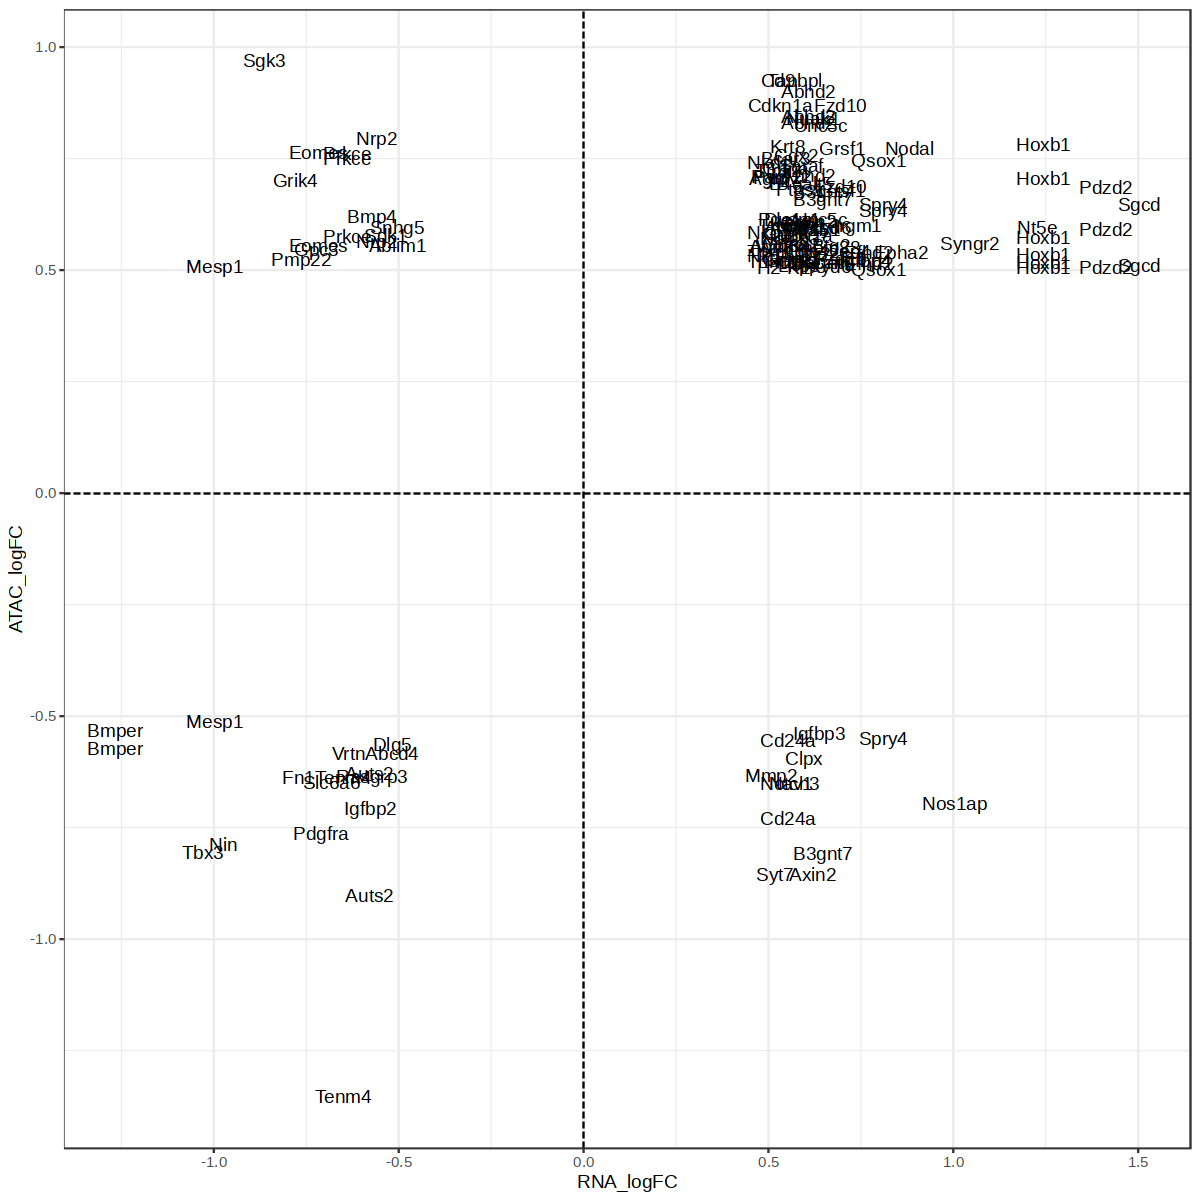

In [144]:
options(repr.plot.height= 10, repr.plot.width=10)
ggplot(DEG_DAR[celltype %in% c('Primitive_Streak', 'Early_Mes_EOi')], aes(RNA_logFC, ATAC_logFC)) + 
    geom_text(aes(label = gene)) + 
    geom_hline(yintercept = 0, linetype = 'longdash') + 
    geom_vline(xintercept = 0, linetype = 'longdash') + 
    theme_bw()

In [219]:
rna.sce$genotype = gsub('KO', 'KD', rna.sce$genotype)

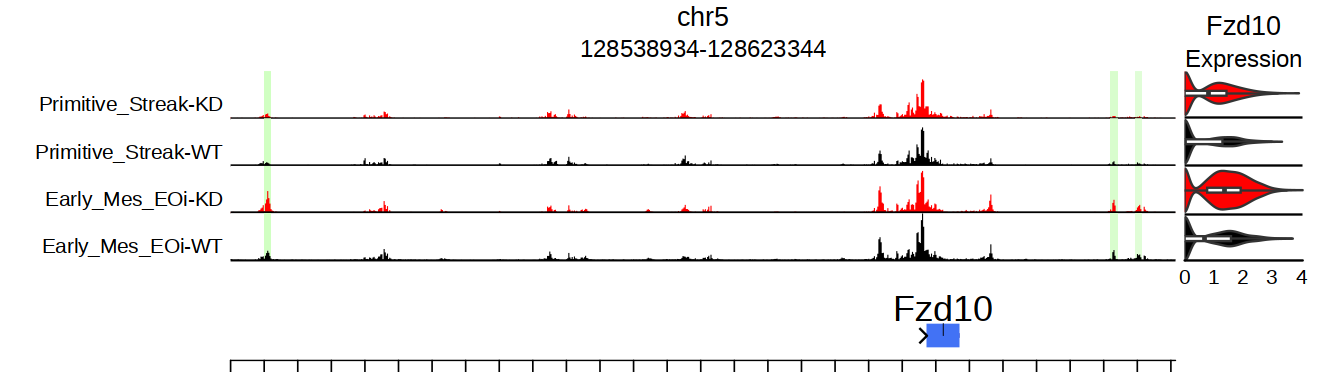

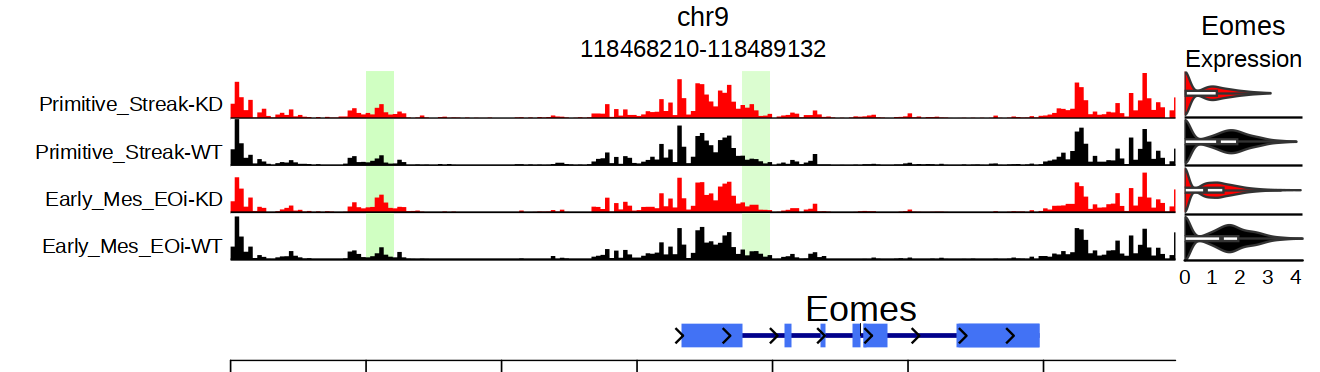

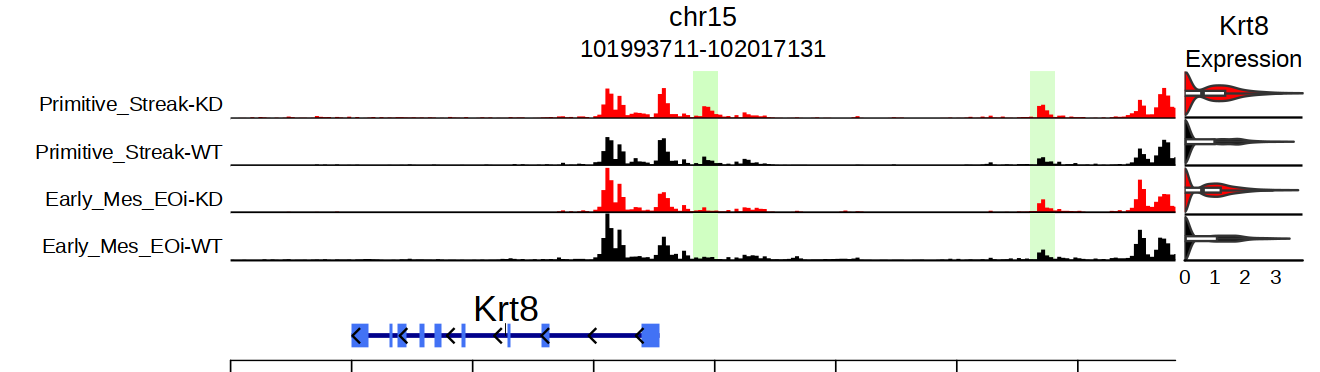

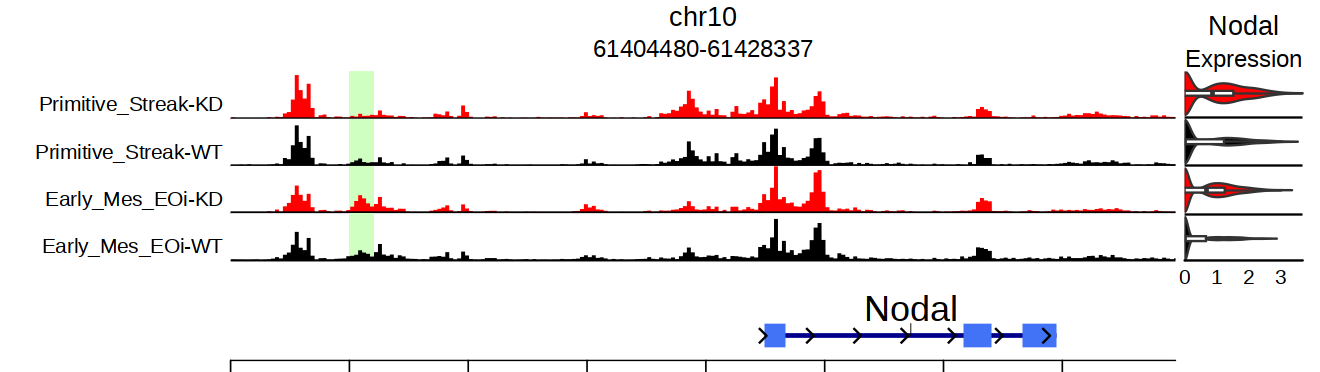

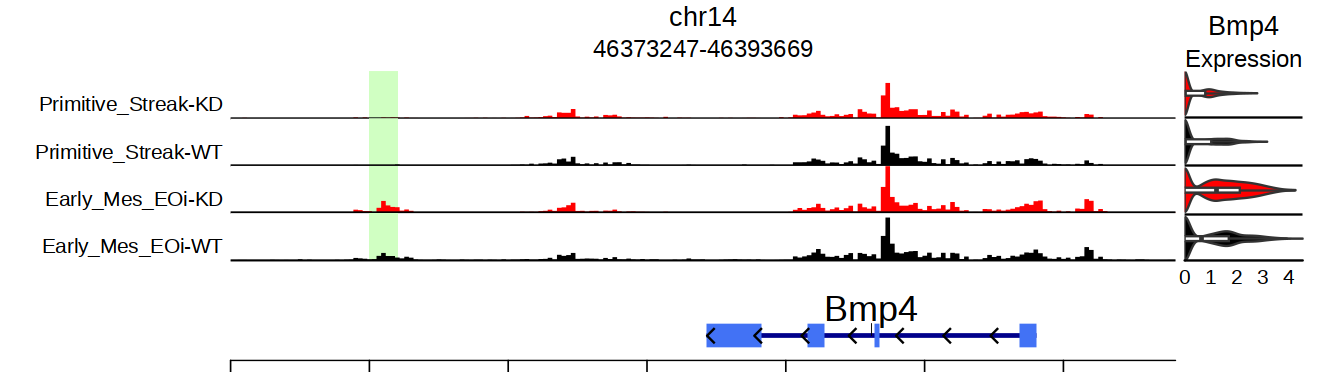

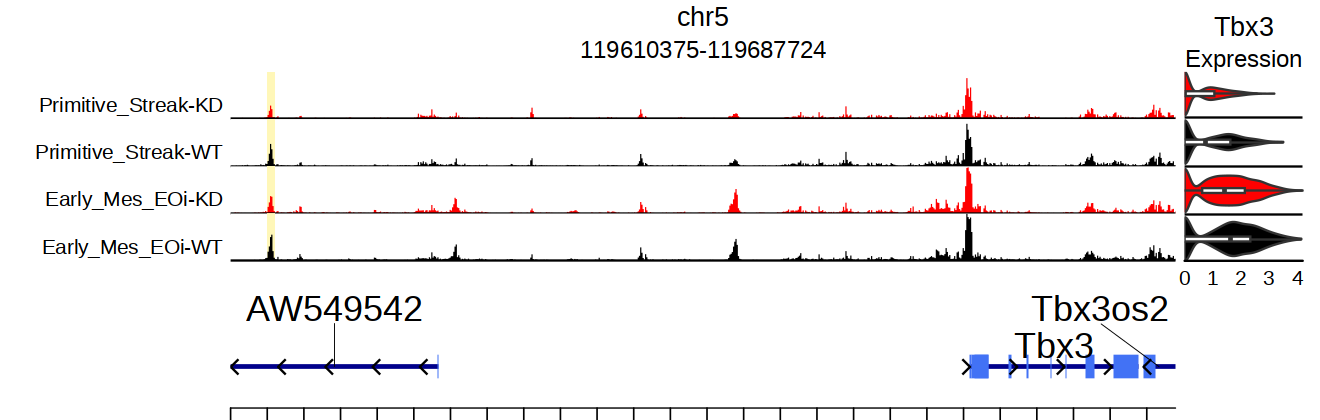

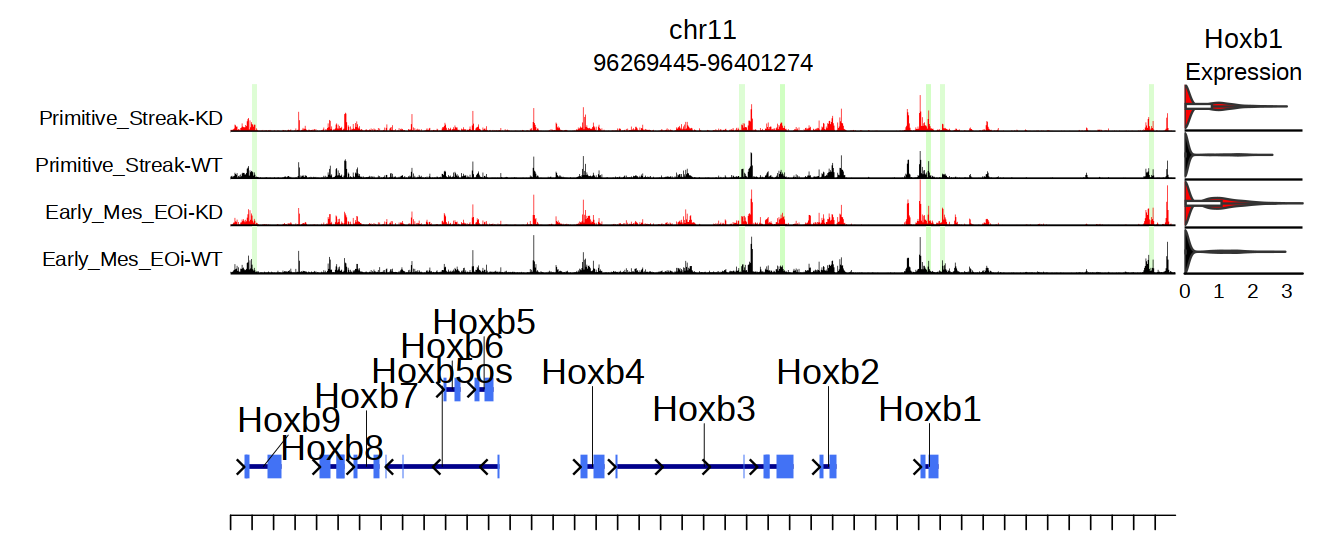

In [256]:
options(repr.plot.height=3.1, repr.plot.width=11)
plot_region('Fzd10')
plot_region('Eomes')
plot_region('Krt8')
plot_region('Nodal')
plot_region('Bmp4')
options(repr.plot.height=3.5, repr.plot.width=11)
plot_region('Tbx3', gene_height = 2.5)
options(repr.plot.height=4.5, repr.plot.width=11)
plot_region('Hoxb1', gene_height = 4.5)

In [261]:
DARs[order(-logFC)][[1,1]]

[1] "chr4:142452517-142453117"

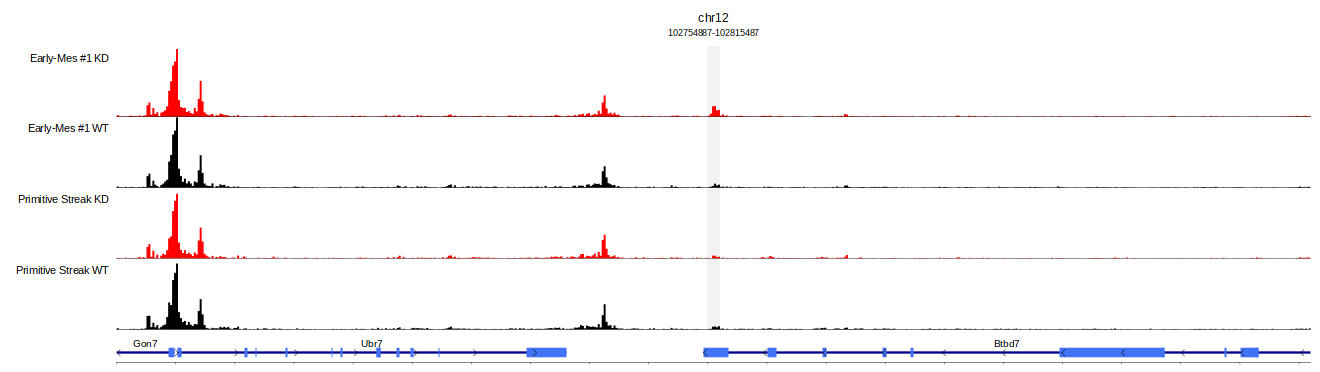

In [242]:
input = DARs[order(-logFC)][[3,1]]
plot_browser_track(gene = NULL, # Only choose one of gene/input_region, otherwise will use region
                              input_region = input, 
                              bigwigs = WT_plot, 
                              extend.upstream = 3e4,
                              extend.downstream = 3e4, 
                              highlight_regions = input,
                              downsample.rate = 1, 
                              no_label = F, 
                              plot_expression = F,
                              background_color = 'white',
                              highlight_color = 'grey95',
                              bw_height = 15, 
                              gene_height = 6,
                              bw_width = 20)

In [32]:
DARs_region = peak_gene_correlation[,c('peak', 'gene', 'cor', 'padj')] %>% 
          merge(., DARs %>% copy() %>%  
                    .[!is.na(logFC)] %>% 
                   setnames(colnames(.)[2:7], paste0('ATAC_', colnames(.)[2:7])),
                by = c('peak'), allow.cartesian=TRUE)

In [33]:
DARs_region[gene == 'Hoxb1']

peak,gene,cor,padj,ATAC_logFC,ATAC_padj_fdr,ATAC_mean_groupA,ATAC_mean_groupB,ATAC_cdr_groupA,ATAC_cdr_groupB,celltype
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
chr11:96272445-96273045,Hoxb1,-0.738,0.0024807417,0.505,7.98e-09,2.10,2.50,0.07,0.15,Early_Mes_EOi
chr11:96340516-96341116,Hoxb1,-0.518,0.0742919345,0.518,4.03e-12,2.52,2.96,0.10,0.19,Early_Mes_EOi
chr11:96346183-96346783,Hoxb1,0.159,0.6883868633,0.781,4.86e-30,2.67,3.35,0.10,0.25,Early_Mes_EOi
chr11:96366508-96367108,Hoxb1,0.389,0.2233733802,0.705,5.96e-25,2.68,3.30,0.11,0.24,Early_Mes_EOi
chr11:96368500-96369100,Hoxb1,0.825,0.0002022421,0.534,3.37e-16,2.85,3.31,0.11,0.24,Early_Mes_EOi
chr11:96397674-96398274,Hoxb1,-0.067,0.8801943807,0.574,3.36e-17,2.72,3.22,0.10,0.22,Early_Mes_EOi


Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation ideoms with `aes()`”


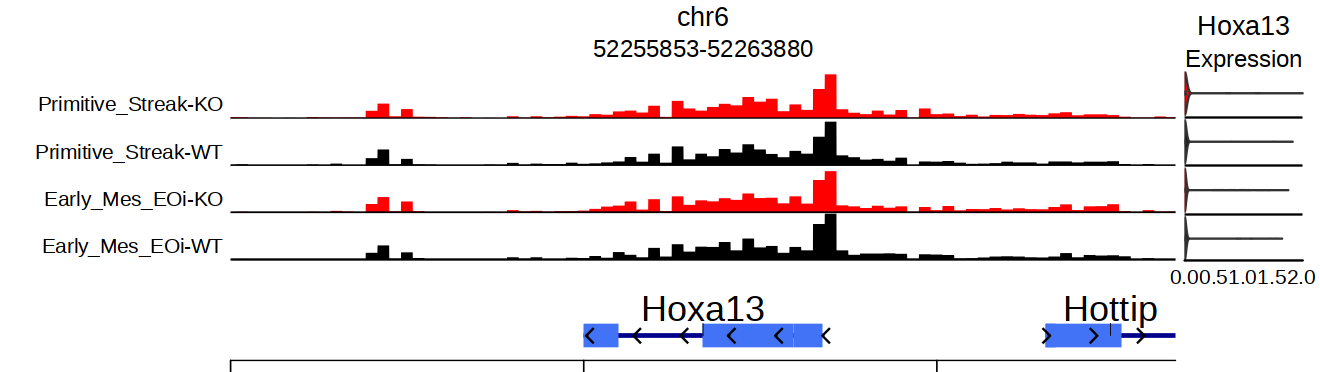

In [39]:
options(repr.plot.height=3.1, repr.plot.width=11)
plot_region('Hoxa13')

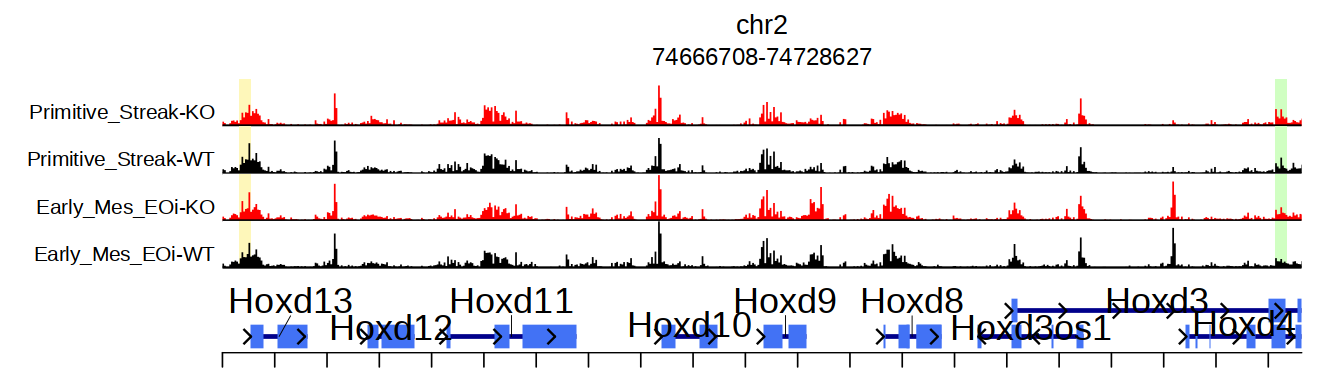

In [48]:
input_gene = 'Hoxd9'
tmp1 = DARs_region[gene %in% input_gene] %>% 
    .[order(-abs(ATAC_logFC))] %>% unique(by = 'peak')
gene_region = ArchRProject@geneAnnotation$genes[grep(paste0('^', input_gene, '$'), ArchRProject@geneAnnotation$genes$symbol)]
peak_regions = as.numeric(str_split(str_split(tmp1$peak, ':') %>% map_chr(2), '-') %>% map_chr(1))
start = min(c(start(ranges(gene_region)), peak_regions))
end = max(c(c(end(ranges(gene_region)), peak_regions + 600)))
input_region = paste0(gene_region@seqnames@values, ':', start, '-', end)

mypal <- colorRampPalette(c("#fff7b8","grey98","#d0ffc2"))(100)
x <- tmp1[, ATAC_logFC]
highlight_colors = map2color(x,mypal, limits = c(-max(abs(c(0,x))), max(abs(c(0,x)))))
names(highlight_colors) = str_split(str_split(tmp1[, peak], ':') %>% map_chr(2), '-') %>% map_chr(1)

options(repr.plot.height=3.1, repr.plot.width=11)
plot_browser_track(gene = NULL, # Only choose one of gene/input_region, otherwise will use region
                              input_region = input_region, 
                              bigwigs = WT_plot, 
                              extend.upstream = 1e3,
                              extend.downstream = 0.9e3, 
                              highlight_regions = tmp1$peak,
                              downsample.rate = 1, 
                              no_label = F, 
                              plot_expression = F,
                              background_color = 'white',
                              highlight_color = highlight_colors,
                              bw_height = 1, 
                              gene_height = 1.5,
                              bw_width = 20)

In [57]:
opts$celltype_v2.colors

PGC           Allantois Allantois_Precursor          Mesenchyme 
          "#FACB12"           "#532C8A"           "#8870ad"           "#cc7818" 
      Posterior_Mes       Early_Mes_EOi    Primitive_Streak       Early_Mes_EOd 
          "#ffbfd0"           "#a0d0fa"           "#DABE99"           "#fc4c5c" 
       HE_Precursor                  HE         Endothelium    Blood_Progenitor 
          "#917057"           "#FBBE92"           "#ff891c"           "#f9decf"

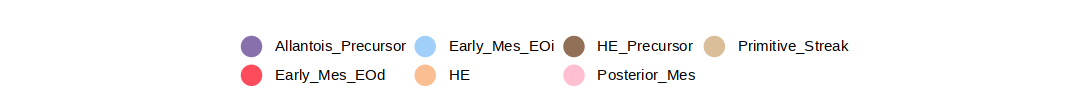

In [70]:
options(repr.plot.width=9, repr.plot.height=0.8)
grid.newpage()                               
grid.draw(
    get_legend(
        ggplot(meta %>% unique(by = 'celltype_v2') %>% .[celltype_v2 %in% c('Primitive_Streak', 'Early_Mes_EOi','Early_Mes_EOd','Posterior_Mes','HE_Precursor', 'HE', 'Allantois_Precursor')], 
               aes(x = 1, y = 1, color = celltype_v2)) + 
            geom_point() + 
            scale_color_manual(values=opts$celltype_v2.colors, guide = guide_legend(override.aes = list(size = 5), nrow = 2), name = '') + 
            theme_void()
    )
)


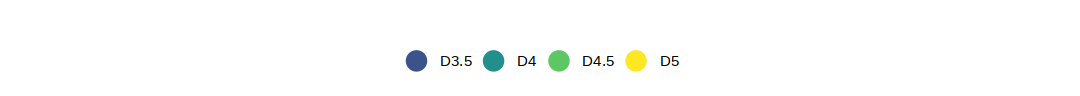

In [68]:
options(repr.plot.width=9, repr.plot.height=0.8)
grid.newpage()                               
grid.draw(
    get_legend(
        ggplot(meta %>% unique(by = 'day'), 
               aes(x = 1, y = 1, color = day)) + 
            geom_point() + 
            scale_color_manual(values=opts$days.colors, guide = guide_legend(override.aes = list(size = 5), nrow = 1), name = '') + 
            theme_void()
    )
)


In [ ]:
guides(fill=guide_legend(nrow=2,byrow=TRUE))

In [58]:
 ggplot(meta %>% unique(by = 'celltype_v2'), 
               aes(x = 1, y = 1, color = celltype_v2)) + 
                     geom_point() + 
                     scale_color_discrete(colors = opts$celltype_v2.colors) + 
                     theme_void()

ERROR: Error in discrete_scale(aesthetics, "hue", hue_pal(h, c, l, h.start, direction), : unused argument (colors = c("#FACB12", "#532C8A", "#8870ad", "#cc7818", "#ffbfd0", "#a0d0fa", "#DABE99", "#fc4c5c", "#917057", "#FBBE92", "#ff891c", "#f9decf"))


In [49]:
head(meta)

cell,barcode,sample,nFeature_RNA,nCount_RNA,mitochondrial_percent_RNA,ribosomal_percent_RNA,alias,day,genotype,⋯,stage.mapped_mnn,cellstage.score_mnn,closest.cell_mnn,celltype_genotype,celltype_extended_genotype,UMAP1,UMAP2,mofa_cluster,celltype_v1,celltype_v2
<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,⋯,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<chr>
2_Eo_DEG_G9_day3_5_VC#AAACAGCCAAAGCGGC-1,AAACAGCCAAAGCGGC-1,2_Eo_DEG_G9_day3_5_VC,2811,5243,3.43,8.03,day3.5_WT_rep2,D3.5,WT,⋯,E7.25,0.84,cell_82119,Nascent_mesoderm-WT,Nascent_mesoderm-WT,-1.81734333,-3.21844925,1,Early_Mes_EOd,Early_Mes_EOd
2_Eo_DEG_G9_day3_5_VC#AAACAGCCAACCTAAT-1,AAACAGCCAACCTAAT-1,2_Eo_DEG_G9_day3_5_VC,5811,20380,4.85,6.79,day3.5_WT_rep2,D3.5,WT,⋯,E7.5,0.40,cell_51826,Mixed_mesoderm-WT,Nascent_mesoderm-WT,-0.37913916,-0.14060377,0,Early_Mes_EOd,Early_Mes_EOd
2_Eo_DEG_G9_day3_5_VC#AAACAGCCATGGAGGC-1,AAACAGCCATGGAGGC-1,2_Eo_DEG_G9_day3_5_VC,4688,13914,12.33,7.05,day3.5_WT_rep2,D3.5,WT,⋯,E7.25,0.56,cell_78069,Mixed_mesoderm-WT,Nascent_mesoderm-WT,-0.99108205,-0.03155522,9,Early_Mes_EOi,Early_Mes_EOi
2_Eo_DEG_G9_day3_5_VC#AAACAGCCATGTTGGC-1,AAACAGCCATGTTGGC-1,2_Eo_DEG_G9_day3_5_VC,3582,8005,5.36,6.68,day3.5_WT_rep2,D3.5,WT,⋯,E7.25,0.52,cell_109501,Mixed_mesoderm-WT,Nascent_mesoderm-WT,0.23929117,-0.75196864,0,Early_Mes_EOd,Early_Mes_EOd
2_Eo_DEG_G9_day3_5_VC#AAACATGCAAGCGATG-1,AAACATGCAAGCGATG-1,2_Eo_DEG_G9_day3_5_VC,5424,16765,6.06,13.81,day3.5_WT_rep2,D3.5,WT,⋯,E7.0,0.68,cell_111439,Nascent_mesoderm-WT,Nascent_mesoderm-WT,-0.07872263,-1.51392176,0,Early_Mes_EOd,Early_Mes_EOd
2_Eo_DEG_G9_day3_5_VC#AAACATGCACCACAAC-1,AAACATGCACCACAAC-1,2_Eo_DEG_G9_day3_5_VC,4221,11058,4.10,6.94,day3.5_WT_rep2,D3.5,WT,⋯,E7.25,0.76,cell_81395,Nascent_mesoderm-WT,Nascent_mesoderm-WT,-0.20114860,-2.08716001,1,Early_Mes_EOd,Early_Mes_EOd
